In [1]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
import re
import os
import pandas as pd
from tqdm import tqdm_notebook
import json

import matplotlib.pylab as plt

project_dir="G:/My Drive/CRG_Dropbox/AljoComputer/Temp"
dir_keypoints="../expts/KeypointsAndDescriptors/validKeyPoints"
dir_descriptors="../expts/KeypointsAndDescriptors/descriptors"

def modelfit(alg, dtrain, train_labels, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain, label=train_labels)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=25)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain, train_labels, eval_metric='auc')

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % accuracy_score(train_labels, dtrain_predictions)
    print "AUC Score (Train): %f" % roc_auc_score(train_labels, dtrain_predprob)
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    


In [2]:
annotation_list = '../expts/annotation_list'
all_annotations = []
with open(annotation_list) as test_list:
    for annotation_file in test_list:
        annotation_file = project_dir + re.sub(".*/20180417_BG57_Midpoint_200micron_30fps/", "/", annotation_file.strip())
        with open(annotation_file) as fin_annotation:
            annotation = json.load(fin_annotation)
            all_annotations.extend(annotation["Annotations"])

print "len(all_annotations):", len(all_annotations)

gt = pd.DataFrame([])
descs = []
for ind, annotation in enumerate(all_annotations):
    parent, file_name = os.path.split(annotation['FrameFile'])
    file_name = os.path.splitext(file_name)[0]
    _, parent_name = os.path.split(parent)
    gt.loc[ind, 'FrameIndex'] = int(annotation['FrameIndexVideo'])
    gt.loc[ind, 'FileName'] = str(file_name.strip())
    gt.loc[ind, 'ParentName'] = str(parent_name.strip())
    for bp in annotation['FrameValueCoordinates']:
        if bp['Name'] == 'LeftDorsalOrgan':
            if (bp['Value']['x_coordinate'] != -1) and (bp['Value']['y_coordinate'] != -1):
                gt.loc[ind, 'LeftDorsalOrgan'] = 1
            else:
                gt.loc[ind, 'LeftDorsalOrgan'] = 0
        elif bp['Name'] == 'RightDorsalOrgan':
            if (bp['Value']['x_coordinate'] != -1) and (bp['Value']['y_coordinate'] != -1):
                gt.loc[ind, 'RightDorsalOrgan'] = 1
            else:
                gt.loc[ind, 'RightDorsalOrgan'] = 0
    desc_file = os.path.join(dir_descriptors, str(parent_name.strip()), str(file_name.strip() + '.csv'))
    try:
        temp = pd.read_csv(desc_file, sep='\t', header=None)
        descs.append(temp.values)
    except:
        temp = pd.DataFrame(np.zeros((1, 128)))
        descs.append(temp.values)
        continue

print "len(descs):", len(descs)

len(all_annotations): 2613
len(descs): 2613


In [3]:
bp = 'LeftDorsalOrgan'
X = gt.index.values
y = gt.loc[:, bp]
train_idx, test_idx, train_labs_idx, test_labs_idx = train_test_split(X, y, test_size=0.30, random_state=42)

train_desc = np.zeros((0,128))
train_labels = np.zeros((0,1))
for i in tqdm_notebook(train_idx):
    train_desc = np.r_[train_desc, descs[i]]
    train_labels = np.r_[train_labels, np.tile(gt.loc[i, bp], (np.shape(descs[i])[0], 1))]


[0]	train-auc:0.732819+0.00172207	test-auc:0.708781+0.00227078
[25]	train-auc:0.862443+0.00106354	test-auc:0.815649+0.00168084
[50]	train-auc:0.895408+0.0010473	test-auc:0.837935+0.00174405
[75]	train-auc:0.915408+0.000947295	test-auc:0.851157+0.00213401
[100]	train-auc:0.930012+0.000540114	test-auc:0.860529+0.00205768
[125]	train-auc:0.941587+0.000663621	test-auc:0.867758+0.00229629
[150]	train-auc:0.950789+0.000528319	test-auc:0.873358+0.00229112
[175]	train-auc:0.958352+0.000105237	test-auc:0.87803+0.00218872
[200]	train-auc:0.964666+0.000570898	test-auc:0.882005+0.00230436
[225]	train-auc:0.969947+0.000757004	test-auc:0.8853+0.00254246
[250]	train-auc:0.974467+0.000610064	test-auc:0.888284+0.00252705
[275]	train-auc:0.978471+0.000821848	test-auc:0.891288+0.00252075
[300]	train-auc:0.981719+0.000734083	test-auc:0.893767+0.00253599
[325]	train-auc:0.984623+0.000605389	test-auc:0.89617+0.00234181
[350]	train-auc:0.986903+0.000465994	test-auc:0.898023+0.00243134
[375]	train-auc:0.98914

C:\Users\Shaul\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9577
AUC Score (Train): 0.992766


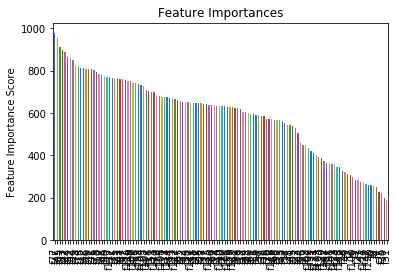

In [5]:
xgb1 = XGBClassifier(
 learning_rate=0.1,
 n_estimators=500,
 max_depth=8,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=20,
 scale_pos_weight=0.64,
 seed=27)

modelfit(xgb1, train_desc, np.ravel(train_labels))

# xgb_param = xgb1.get_xgb_params()
# xgtrain = xgb.DMatrix(train_desc, label=np.ravel(train_labels))
# cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgb1.get_params()['n_estimators'], nfold=5,
#                   metrics='auc', early_stopping_rounds=50, verbose_eval=25)
# xgb1.set_params(n_estimators=cvresult.shape[0])

# xgb1.fit(train_desc, np.ravel(train_labels), eval_metric='auc')

# #Predict training set:
# dtrain_predictions = xgb1.predict(train_desc)
# dtrain_predprob = xgb1.predict_proba(train_desc)[:,1]

# #Print model report:
# print "\nModel Report"
# print "Accuracy : %.4g" % accuracy_score(np.ravel(train_labels), dtrain_predictions)
# print "AUC Score (Train): %f" % roc_auc_score(np.ravel(train_labels), dtrain_predprob)

# feat_imp = pd.Series(xgb1.get_booster().get_fscore()).sort_values(ascending=False)
# feat_imp.plot(kind='bar', title='Feature Importances')
# plt.ylabel('Feature Importance Score')

In [ ]:
!git add -A

In [ ]:
!git commit -m "removed error in modelfit function"

In [ ]:
!git push

In [ ]:
param_test1 = {'max_depth': [4, 8, 16, 32], 'min_child_weight': range(1, 7, 2)}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=24, scale_pos_weight=1, seed=27), 
                        param_grid = param_test1, scoring='roc_auc', n_jobs=24, iid=False, cv=5)
gsearch1.fit(train, train_labels)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=24,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

In [ ]:
param_test2b = {
 'min_child_weight':[6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=4,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=24,iid=False, cv=5)
gsearch2b.fit(train[predictors],train[target])

In [ ]:
modelfit(gsearch3.best_estimator_, train, predictors)
gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

In [ ]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=24,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

In [ ]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=24,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train, predictors)

In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=24,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

In [ ]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=24,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])